# Installations and Imports

In [1]:
%%capture
!pip install mujoco mujoco_mjx brax playground
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
!apt-get update
!apt-get install -y libosmesa6-dev libgl1-mesa-glx libglfw3 patchelf

In [2]:
import jax
import numpy as np
import matplotlib.pyplot as plt
import mediapy
import os
from tqdm import tqdm

os.environ["MUJOCO_GL"] = "egl"

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [3]:
# import mujoco after setting MUJOCO_GL to prevent errors in video rendering
import mujoco

# Clone Repository

In [4]:
!git clone https://github.com/shaoanlu/llm_mjx_go1_playground.git

Cloning into 'llm_mjx_go1_playground'...
remote: Enumerating objects: 414, done.
remote: Counting objects: 100% (414/414), done.
remote: Compressing objects: 100% (291/291), done.
remote: Total 414 (delta 201), reused 289 (delta 107), pack-reused 0 (from 0)
Receiving objects: 100% (414/414), 6.56 MiB | 11.51 MiB/s, done.
Resolving deltas: 100% (201/201), done.


In [5]:
%cd llm_mjx_go1_playground

/content/llm_mjx_go1_playground


In [6]:
!pwd

/content/llm_mjx_go1_playground


# Run simulation

In [7]:
from src.environment.env_wrapper import Go1Env
from src.control.algorithms.mlp import MLPPolicy, MLPPolicyParams
from src.control.controller_factory import ConfigFactory, ControllerFactory

mujoco_menagerie not found. Downloading...


Cloning mujoco_menagerie: ██████████| 100/100 [00:34<00:00]


Checking out commit 5e6af47a49bf8ae27581615b54045107b20ce584
Successfully downloaded mujoco_menagerie


In [8]:
velocity_kick_range = [0.0, 0.0]  # Disable velocity kick.
kick_duration_range = [0.05, 0.2]


def sample_pert(rng, env, state):
    """
    Random purterbation to the robot
    """
    rng, key1, key2 = jax.random.split(rng, 3)
    pert_mag = jax.random.uniform(key1, minval=velocity_kick_range[0], maxval=velocity_kick_range[1])
    duration_seconds = jax.random.uniform(key2, minval=kick_duration_range[0], maxval=kick_duration_range[1])
    duration_steps = jax.numpy.round(duration_seconds / env.dt).astype(jax.numpy.int32)
    state.info["pert_mag"] = pert_mag
    state.info["pert_duration"] = duration_steps
    state.info["pert_duration_seconds"] = duration_seconds
    return rng

## Demo 1: Yaw Command Control With The Factory Pattern
### Instantiate simulator and controller
Choose `env_name` between `Go1Handstand` and `Go1JoystickFlatTerrain`. This parameter determines the type of controller created by the factory.

In [9]:
# instantiate mujoco Env
env_name = "Go1JoystickFlatTerrain"  # Choose between Go1Handstand and Go1JoystickFlatTerrain
rng = jax.random.PRNGKey(0)
env = Go1Env(env_name=env_name)

# Instantiate controller based on env_name
factory = ControllerFactory()
factory.register_controller(MLPPolicy, MLPPolicy)
controller_config = {"npy_path": f"src/control/nn_params/{env_name}"}
mlp_params = MLPPolicyParams.from_dict(controller_config)
controller = factory.build(params=mlp_params)

In [10]:
rollout = []
modify_scene_fns = []
swing_peak = []
linvel = []
angvel = []
ref_commands = []

# Play around the controller by modifying command during runtime
cmd_yaw = np.pi
command = jax.numpy.array([0, 0, cmd_yaw])

# start closed-loop sim
state = env.reset(rng)
for i in tqdm(range(env.env_cfg.episode_length)):
    # halve target yaw velocity every 250 steps
    if (env_name == "Go1JoystickFlatTerrain") and (i % 250 == 0):
        cmd_yaw /= 2
        command = jax.numpy.array([0, 0, cmd_yaw])
        state.info["command"] = command
    try:
        if state.info["steps_since_last_pert"] < state.info["steps_until_next_pert"]:
            rng = sample_pert(rng, env, state)
    except:
        pass
    _, rng = jax.random.split(rng)  # this will randomize perturbation

    ctrl = controller.control(state.obs["state"])  # controller step
    state = env.step(state, ctrl)  # simulator step

    # record
    rollout.append(state)
    ref_commands.append(command)
    linvel.append(env.get_global_linvel(state.data))
    angvel.append(env.get_gyro(state.data))
    if env_name == "Go1JoystickFlatTerrain":
        swing_peak.append(state.info["swing_peak"])

100%|██████████| 1000/1000 [00:58<00:00, 17.21it/s]


### Visualize Simulation Result

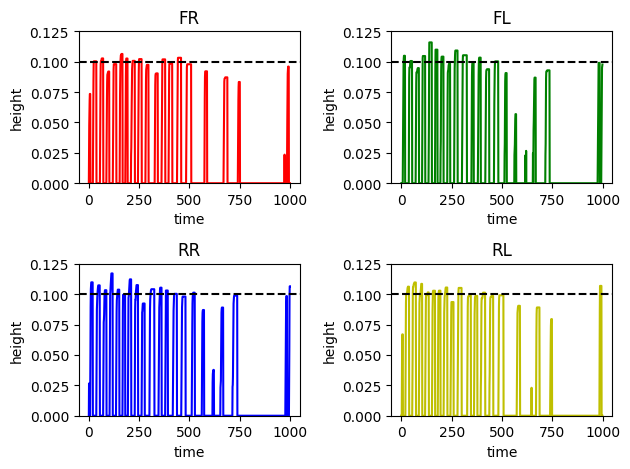

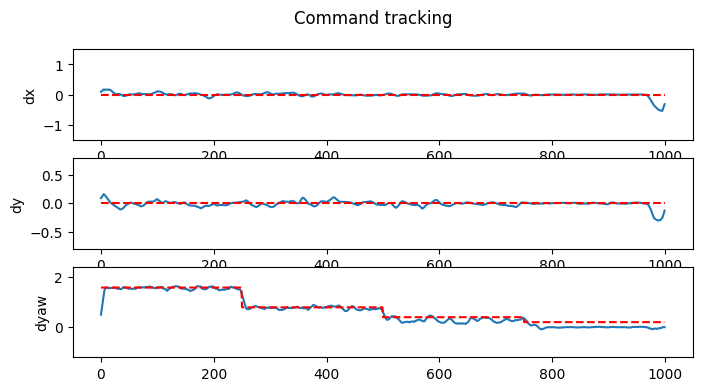

In [11]:
# visualization
# Plot each foot in a 2x2 grid.
if env_name == "Go1JoystickFlatTerrain":
    swing_peak = jax.numpy.array(swing_peak)
    names = ["FR", "FL", "RR", "RL"]
    colors = ["r", "g", "b", "y"]
    fig, axs = plt.subplots(2, 2)
    for i, ax in enumerate(axs.flat):
        ax.plot(swing_peak[:, i], color=colors[i])
        ax.set_ylim([0, env.env_cfg.reward_config.max_foot_height * 1.25])
        ax.axhline(env.env_cfg.reward_config.max_foot_height, color="k", linestyle="--")
        ax.set_title(names[i])
        ax.set_xlabel("time")
        ax.set_ylabel("height")
    plt.tight_layout()
    plt.show()

    linvel_x = jax.numpy.array(linvel)[:, 0]
    linvel_y = jax.numpy.array(linvel)[:, 1]
    angvel_yaw = jax.numpy.array(angvel)[:, 2]

    # Plot whether velocity is within the command range.
    linvel_x = jax.numpy.convolve(linvel_x, jax.numpy.ones(10) / 10, mode="same")
    linvel_y = jax.numpy.convolve(linvel_y, jax.numpy.ones(10) / 10, mode="same")
    angvel_yaw = jax.numpy.convolve(angvel_yaw, jax.numpy.ones(10) / 10, mode="same")

    fig, axes = plt.subplots(3, 1, figsize=(8, 4))
    axes[0].plot(linvel_x)
    axes[1].plot(linvel_y)
    axes[2].plot(angvel_yaw)

    axes[0].set_ylim(-env.env_cfg.command_config.a[0], env.env_cfg.command_config.a[0])
    axes[1].set_ylim(-env.env_cfg.command_config.a[1], env.env_cfg.command_config.a[1])
    axes[2].set_ylim(-env.env_cfg.command_config.a[2], env.env_cfg.command_config.a[2] * 2)

    ref_cmd = jax.numpy.vstack(ref_commands)
    for i, ax in enumerate(axes):
        ax.plot(ref_cmd[:, i], color="red", linestyle="--")

    labels = ["dx", "dy", "dyaw"]
    for i, ax in enumerate(axes):
        ax.set_ylabel(labels[i])
    fig.suptitle("Command tracking")
else:
    print("No signal plots for Go1Handstand")

### Video rendering

In [ ]:
render_every = 2
fps = 1.0 / env.dt / render_every
traj = rollout[::render_every]

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True
scene_option.geomgroup[3] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False

frames = env.render(traj, camera="track", scene_option=scene_option, height=480, width=640)
mediapy.show_video(frames, fps=fps, loop=False)

## Demo 2: Acrobatic movement With The Strategy Pattern
This demo demonstrates the usage of strategy pattern to manage switching controller at runtime.

The controller is able to perform 4 tasks, and achieves acrobatic movement uninterrupted.
- Handstand
- Footstand
- Yaw command tracking
- recovery from failures

In [16]:
from typing import Dict

from src.control.acrobat_controller import create_acrobat_controller_manager, Go1ControllerManagerParams
from src.control.acrobat_controller import Go1ControllerType
from src.recovery_checker import RecoverState

In [14]:
# instantiate mujoco Env
env_name = "Go1Handstand"  # Fixed to Go1Handstand
rng = jax.random.PRNGKey(42)
env = Go1Env(env_name=env_name)

There are three polocies available for Go1 env and are defined in `Go1ControllerType` as below
```python
class Go1ControllerType(Enum):
    JOYSTICK = auto()
    HANDSTAND = auto()
    FOOTSTAND = auto()
    GETUP = auto()
```

In [18]:
def print_switch_controller(
    prev_controller_type: Go1ControllerType, current_controller_type: Go1ControllerType, step: int
):
    """Helper function to print active controller type"""
    if current_controller_type != prev_controller_type:
        print(f"\n[Step {i}] Switch from {prev_controller_type} to {current_controller_type}\n")


# Create controller manager configuration
config = Go1ControllerManagerParams(
    controllers={
        Go1ControllerType.JOYSTICK: MLPPolicyParams.from_dict(
            {"npy_path": "src/control/nn_params/Go1JoystickFlatTerrain"}
        ),
        Go1ControllerType.FOOTSTAND: MLPPolicyParams.from_dict({"npy_path": "src/control/nn_params/Go1Footstand"}),
        Go1ControllerType.HANDSTAND: MLPPolicyParams.from_dict({"npy_path": "src/control/nn_params/Go1Handstand"}),
        Go1ControllerType.GETUP: MLPPolicyParams.from_dict({"npy_path": "src/control/nn_params/Go1Getup"}),
    },
    default_controller_type=Go1ControllerType.FOOTSTAND,
    command_dim=3,
)

# Create controller manager, this class provides a switch_controller() method for changing controller at runtime
controller_manager = create_acrobat_controller_manager(controller_factory=ControllerFactory(), config=config)

### Run closed-loop simulation

In [19]:
rollout = []

# Play around the controller by modifying command during runtime
joystick_command = jax.numpy.array([0, 0, np.pi / 2])
controller_manager.set_command(joystick_command)
prev_controller_type = controller_manager._active_type

# recover stae machine
recover_state = RecoverState(env)

# start closed-loop sim
state = env.reset(rng)
sim_steps = int(env.env_cfg.episode_length * 1.5)
for i in tqdm(range(sim_steps)):
    state.info["command"] = joystick_command
    try:
        if state.info["steps_since_last_pert"] < state.info["steps_until_next_pert"]:
            rng = sample_pert(rng, env, state)
    except:
        pass
    _, rng = jax.random.split(rng)  # this will randomize perturbation

    # Switch controllers based on timestep
    if i <= sim_steps // 3:
        controller_manager.switch_controller(Go1ControllerType.HANDSTAND)
    elif i > 2 * sim_steps // 3:
        controller_manager.switch_controller(Go1ControllerType.FOOTSTAND)
    else:
        controller_manager.switch_controller(Go1ControllerType.JOYSTICK)

    # switch to recover controller if robot falls down
    if recover_state.check(state=state, step=i):
        controller_manager.switch_controller(Go1ControllerType.GETUP)

    # print out controller switch if detected
    print_switch_controller(prev_controller_type, controller_manager._active_type, i)
    prev_controller_type = controller_manager._active_type

    # controller & simulator step
    # note that the controll manager take the state as input instead of state.obs["state"]
    ctrl = controller_manager.control(state)
    state = env.step(state, ctrl)

    # record
    rollout.append(state)

  0%|          | 0/750 [00:00<?, ?it/s]


[Step 0] Switch from Go1ControllerType.FOOTSTAND to Go1ControllerType.HANDSTAND



 34%|███▎      | 252/750 [01:00<00:08, 61.24it/s]


[Step 251] Switch from Go1ControllerType.HANDSTAND to Go1ControllerType.JOYSTICK



/content/llm_mjx_go1_playground/src/control/algorithms/mlp.py:80: RuntimeWarning: overflow encountered in exp
  x = x / (1 + np.exp(-1 * x))  # brax PPO training defaults to swish as the activation func
 37%|███▋      | 278/750 [01:01<00:07, 60.39it/s]


[Step 277] Switch from Go1ControllerType.JOYSTICK to Go1ControllerType.GETUP



 46%|████▌     | 346/750 [01:02<00:07, 57.19it/s]


[Step 340] Switch from Go1ControllerType.GETUP to Go1ControllerType.JOYSTICK



 68%|██████▊   | 510/750 [01:05<00:03, 62.47it/s]


[Step 501] Switch from Go1ControllerType.JOYSTICK to Go1ControllerType.FOOTSTAND



100%|██████████| 750/750 [01:08<00:00, 10.88it/s]


### Video rendering

In [ ]:
render_every = 2  # render every 2 steps
fps = 1.0 / env.dt / render_every
traj = rollout[::render_every]

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True
scene_option.geomgroup[3] = False  # set True to visualize collision geom of legs and body (assume rgba defined in xml)
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False
# scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONVEXHULL] = True

frames = env.render(traj, camera="track", scene_option=scene_option, height=480, width=640)
mediapy.show_video(frames, fps=fps, loop=False)

In [ ]:
mediapy.write_video("tmp.mp4", frames, fps=fps)